
# Wikidata rule suggestions


This notebook presents some possible rules that could be extacted from Wikidata.

Note that Wikidata and DBpedia switch the position of the object and subject.
So **P40[Child](A, B)** in Wikidata means that A is the child of B, while in DBpedia **child(A, B)** means that A has child B.


---
### **Rule 1**: P26[Spouse](A, B) -> P26[Spouse](B, A)
"If A is the spouse of B, then B is a spouse of A."

---
### **Rule 2**: P25[Mother](A, B) -> P40[Child](B, A)
"If A is the mother of B, then B is the child of A"

---
### **Rule 3**: p22[Father](A, B) -> P40[Child](B, A)
"If A is the father of B, then B is a child of A."

---
### **Rule 4**: P185[doctoralStudent](A, B) -> P184[doctoralAdvisor](B, A)
"If A is the doctoral student of B, then B is the doctoral advisor of A."

---

### **Rule 5**: P800[notableWork](A, B) -> P170[creator](B, A)
"If A is the notable work of B, then B is the creator of A."

---
### **Rule 6**: P1196[mannerOfDeath](A, Q171558[accident]) -> P184[causeOfDeath](A, Q171558[accident])
"If the manner of A's death was an accident, then the cause of A's death was a accident."

---

In [1]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from pykeen.datasets import Wikidata5M
import pykeen
import tensorflow as tf
import pandas as pd
import numpy as np
np.random.seed(0)
from signature_tools import subset_by_signature, subset_by_strict_signature, subset_by_frequency, most_frequent_objects, most_frequent_predicates, most_frequent_targets
from ampligraph.evaluation import train_test_split_no_unseen 
from ampligraph.latent_features import ComplEx
from ampligraph.latent_features import save_model
from ampligraph.evaluation import evaluate_performance
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import save_model, restore_model
from ampligraph.discovery import discover_facts, find_clusters, find_duplicates, find_nearest_neighbours

In [2]:
data_unprocessed = Wikidata5M()
data_unprocessed.summarize()

WARNING - You're trying to map triples with 156 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
WARNING - In total 156 from 5133 triples were filtered out
WARNING - You're trying to map triples with 180 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
WARNING - In total 180 from 5163 triples were filtered out
Wikidata5M (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    4594149     822           20614279
Testing     4594149     822               4977
Validation  4594149     822               4983
Total       -           -             20624239
Head    Relation    tail
------  ----------  --------
Q1      P1343       Q602358
Q1      P1419       Q1647152
Q1      P1552       Q11412
Q1      P2184       Q136407
Q1      P2670       Q18343



In [3]:
# extract all the data into a numpy array of triples
train_Wikidata = data_unprocessed.training.triples
test_Wikidata = data_unprocessed.testing.triples
validation_Wikidata = data_unprocessed.validation.triples
data_Wikidata = np.concatenate((train_Wikidata, test_Wikidata, validation_Wikidata))
data_Wikidata = data_Wikidata.astype('object') # used to have datatype '<U95' which was problematic for signature_tools functions

WARNING - Reconstructing all label-based triples. This is expensive and rarely needed.
WARNING - Reconstructing all label-based triples. This is expensive and rarely needed.
WARNING - Reconstructing all label-based triples. This is expensive and rarely needed.


In [4]:
top_objects = most_frequent_objects(data_Wikidata, n=10000)

In [7]:
most_frequent_predicates(data_Wikidata, n=100)

array([[3841627, 'P31'],
       [1375274, 'P17'],
       [1146848, 'P27'],
       [1101408, 'P106'],
       [919905, 'P54'],
       [919489, 'P131'],
       [856424, 'P19'],
       [838752, 'P735'],
       [514458, 'P161'],
       [485845, 'P641'],
       [439909, 'P69'],
       [429980, 'P47'],
       [404947, 'P421'],
       [374369, 'P105'],
       [370254, 'P136'],
       [348802, 'P171'],
       [279197, 'P20'],
       [261001, 'P495'],
       [238803, 'P1412'],
       [222716, 'P1344'],
       [183473, 'P175'],
       [182448, 'P166'],
       [181086, 'P413'],
       [154179, 'P264'],
       [149046, 'P155'],
       [141736, 'P156'],
       [136593, 'P364'],
       [136331, 'P361'],
       [126546, 'P102'],
       [108630, 'P150'],
       [108322, 'P734'],
       [99586, 'P57'],
       [96454, 'P463'],
       [95780, 'P279'],
       [94036, 'P407'],
       [82598, 'P159'],
       [80172, 'P108'],
       [76208, 'P39'],
       [75654, 'P3373'],
       [71660, 'P937'],
       [7047

In [5]:
top_targets = most_frequent_targets(data_Wikidata, n=10000)

In [6]:
# P8810 = parent of the subject. Only use if neither father (P22) nor mother (P25) is applicable
#P24 = child
#P26 = spouse
# P25 mother of the subject. For stepmother, use "stepparent" (P3448)
#P1038 = relative
#P3373 = sibling
#P3448 = stepparent
family_predicates_dict = {
    'P24': 'child', 
    'P22' : 'father', 
    'P25' : 'mother',
    'P26' : 'spouse', 
    'P1038' : 'relative', 
    'P3373' : 'sibling', 
    'P3448' : 'stepparent'
}
family_subset = subset_by_signature(data_Wikidata, [], ['P24', 'P22', 'P25', 'P26', 'P1038', 'P3373', 'P3448'], [])
family_subset[:,1] = np.array([family_predicates_dict[p] for p in family_subset[:,1]]) # convert predicates to understandable strings

In [41]:
family_relations = list(family_predicates_dict.values())

In [11]:
subject_entities = top_targets[:,1]
object_entities = top_objects[:,1]

In [13]:
entities_subset = np.concatenate([subject_entities, object_entities[~np.isin(object_entities,subject_entities)]])

In [15]:
entities_subset.shape

(19058,)

In [26]:
entities_subset.shape

(19058,)

## Rule minig
Use AMIE+ to mine rules. Call jar file from https://github.com/lajus/amie using this command:

*java -jar amie-dev.jar -bias lazy -full -noHeuristics -ostd [TSV file] > [txt file to save rules in]

In [121]:
'''UNCOMMENT TO SAVE NEW SUBSET'''
pd.DataFrame(family_subset).to_csv("family_KB.txt", sep = "\t", header=None, index=None) # remember to later rename to tsv filetype

### Manual work:

1. rename "family_KB.txt" to "family_KB.csv"
2. Mine rules with command:
```java -jar amie-milestone-intKB.jar -bias lazy -full -noHeuristics -ostd family_KB.tsv > family_mined_rules.txt```
3. Remove useless text so that family_mined_rules.txt only contains the mined rules. Save as family_mined_rules_cleaned.txt

In [105]:
family_mining_results = pd.read_csv("family_mined_rules_cleaned.txt", sep="\t", names=["Rule", "Head_Coverage_A", "PCA_Confidence_A", "Positive_Examples_A", "PCA_Body_size_A", "Functional_variable"], skiprows = 1)

In [106]:
family_mining_results

,Rule,Head_Coverage_A,PCA_Confidence_A,Positive_Examples_A,PCA_Body_size_A,Functional_variable
0,?b relative ?a => ?a stepparent ?b,0.056604,0.750000,6,8,-1
1,?b relative ?a => ?a relative ?b,0.551117,0.846306,2566,3032,-2
2,?b spouse ?a => ?a spouse ?b,0.947832,0.992355,44132,44472,-1
3,?b sibling ?a => ?a sibling ?b,0.961588,0.989634,72748,73510,-2
4,?b relative ?h ?a sibling ?h => ?a ste...,0.018868,0.500000,2,4,-1
...,...,...,...,...,...,...
59,?a father ?h ?b father ?h => ?a siblin...,0.773231,0.658865,58498,88786,-2
60,?h sibling ?a ?b sibling ?h => ?a sibl...,0.716023,0.584857,54170,92621,-2
61,?h sibling ?b ?a sibling ?h => ?a sibl...,0.721059,0.588151,54551,92750,-2
62,?a sibling ?h ?b sibling ?h => ?a sibl...,0.718680,0.590059,54371,92145,-2


In [6]:
# Extract subset contaning 90% of the data
random_subset_mask = np.random.choice([False, True], len(family_subset), p=[0.1, 0.9])
family_subset_subset = family_subset[random_subset_mask]

In [129]:
'''UNCOMMENT TO SAVE NEW SUBSET'''
#pd.DataFrame(family_subset_subset).to_csv("family_random_subset_KB.txt", sep = "\t", header=None, index=None)

### Manual work:

1. rename "family_random_subset_KB.txt" to "family_random_subset_KB.csv"
2. Mine rules with command: ```java -jar amie-milestone-intKB.jar -bias lazy -full -noHeuristics -ostd family_random_subset_KB.tsv > family_random_subset_mined_rules.txt```
3. Remove useless text so that family_random_subset_mined_rules.txt only contains the mined rules. Save as family_random_subset_mined_rules_cleaned.txt

In [104]:
family_random_subset_mining_results = pd.read_csv("family_random_subset_mined_rules_cleaned.txt", sep="\t", names=["Rule", "Head_Coverage_B", "PCA_Confidence_B", "Positive_Examples_B", "PCA_Body_size_B", "Functional_variable"], skiprows = 1)

In [108]:
common_rules = pd.merge(family_mining_results, family_random_subset_mining_results, how='inner', on=['Rule', "Functional_variable"])
uncommon_rules = pd.concat([family_mining_results, family_random_subset_mining_results]).drop_duplicates(["Rule"], keep=False)
all_rules = pd.merge(family_mining_results, family_random_subset_mining_results, how='outer', on=['Rule'])

In [119]:
uncommon_rules

,Rule,Head_Coverage_A,PCA_Confidence_A,Positive_Examples_A,PCA_Body_size_A,Functional_variable,Head_Coverage_B,PCA_Confidence_B,Positive_Examples_B,PCA_Body_size_B
0,?b relative ?a => ?a stepparent ?b,0.056604,0.750000,6.0,8.0,-1,NaN,NaN,NaN,NaN
4,?b relative ?h ?a sibling ?h => ?a ste...,0.018868,0.500000,2.0,4.0,-1,NaN,NaN,NaN,NaN
5,?a mother ?h ?b spouse ?h => ?a steppa...,0.283019,0.508475,30.0,59.0,-1,NaN,NaN,NaN,NaN
6,?b relative ?h ?h sibling ?a => ?a ste...,0.018868,0.500000,2.0,4.0,-1,NaN,NaN,NaN,NaN
7,?a father ?h ?h spouse ?b => ?a steppa...,0.188679,0.384615,20.0,52.0,-1,NaN,NaN,NaN,NaN
8,?a sibling ?h ?h stepparent ?b => ?a s...,0.160377,0.894737,17.0,19.0,-1,NaN,NaN,NaN,NaN
9,?g father ?b ?a spouse ?g => ?a steppa...,0.056604,0.300000,6.0,20.0,-1,NaN,NaN,NaN,NaN
10,?g father ?b ?g spouse ?a => ?a steppa...,0.056604,0.285714,6.0,21.0,-1,NaN,NaN,NaN,NaN
11,?a father ?h ?b spouse ?h => ?a steppa...,0.188679,0.384615,20.0,52.0,-1,NaN,NaN,NaN,NaN
12,?a mother ?g ?g spouse ?b => ?a steppa...,0.283019,0.526316,30.0,57.0,-1,NaN,NaN,NaN,NaN


In [102]:
len(common_rules)

41

In [112]:
np.mean(family_random_subset_mining_results.Head_Coverage_B)

0.2506143195454546

In [115]:
np.mean(family_mining_results.Head_Coverage_A)

0.22897365800000002

In [116]:
np.mean(family_mining_results.PCA_Confidence_A)

0.453455621203125

In [117]:
np.mean(family_random_subset_mining_results.PCA_Confidence_B)

0.4669714059999999

In [94]:
all_rules[:50]

,Rule,Head Coverage A,PCA Confidence A,Positive Examples A,PCA Body size A,Functional variable_x,Head Coverage B,PCA Confidence B,Positive Examples B,PCA Body size B,Functional variable_y
0,?b relative ?a => ?a stepparent ?b,0.056604,0.750000,6.0,8.0,-1.0,NaN,NaN,NaN,NaN,NaN
1,?b relative ?a => ?a relative ?b,0.551117,0.846306,2566.0,3032.0,-2.0,0.489102,0.799217,2042.0,2555.0,-2.0
2,?b spouse ?a => ?a spouse ?b,0.947832,0.992355,44132.0,44472.0,-1.0,0.851667,0.974573,35684.0,36615.0,-1.0
3,?b sibling ?a => ?a sibling ?b,0.961588,0.989634,72748.0,73510.0,-2.0,0.866911,0.917226,59184.0,64525.0,-2.0
4,?b relative ?h ?a sibling ?h => ?a ste...,0.018868,0.500000,2.0,4.0,-1.0,NaN,NaN,NaN,NaN,NaN
5,?a mother ?h ?b spouse ?h => ?a steppa...,0.283019,0.508475,30.0,59.0,-1.0,NaN,NaN,NaN,NaN,NaN
6,?b relative ?h ?h sibling ?a => ?a ste...,0.018868,0.500000,2.0,4.0,-1.0,NaN,NaN,NaN,NaN,NaN
7,?a father ?h ?h spouse ?b => ?a steppa...,0.188679,0.384615,20.0,52.0,-1.0,NaN,NaN,NaN,NaN,NaN
8,?a sibling ?h ?h stepparent ?b => ?a s...,0.160377,0.894737,17.0,19.0,-1.0,NaN,NaN,NaN,NaN,NaN
9,?g father ?b ?a spouse ?g => ?a steppa...,0.056604,0.300000,6.0,20.0,-1.0,NaN,NaN,NaN,NaN,NaN


In [200]:
all_rules.shape

(67, 11)

In [202]:
common_rules.shape

(41, 10)

In [203]:
uncommon_rules.shape

(26, 10)

In [123]:
common_rules["HC_Diff"] = common_rules["Head_Coverage_B"] - common_rules["Head_Coverage_A"]
common_rules["PCA_Conf_Diff"] = common_rules["PCA_Confidence_B"] - common_rules["PCA_Confidence_A"]
common_rules["Pos_Ex_Diff"] = common_rules["Positive_Examples_B"] - common_rules["Positive_Examples_A"]
common_rules["PCA_Body_Size_Diff"] = common_rules["PCA_Body_size_B"] - common_rules["PCA_Body_size_A"]

In [124]:
common_rules

,Rule,Head_Coverage_A,PCA_Confidence_A,Positive_Examples_A,PCA_Body_size_A,Functional_variable,Head_Coverage_B,PCA_Confidence_B,Positive_Examples_B,PCA_Body_size_B,HC_Diff,PCA_Conf_Diff,Pos_Ex_Diff,PCA_Body_Size_Diff
0,?b relative ?a => ?a relative ?b,0.551117,0.846306,2566,3032,-2,0.489102,0.799217,2042,2555,-0.062015,-0.047089,-524,-477
1,?b spouse ?a => ?a spouse ?b,0.947832,0.992355,44132,44472,-1,0.851667,0.974573,35684,36615,-0.096165,-0.017781,-8448,-7857
2,?b sibling ?a => ?a sibling ?b,0.961588,0.989634,72748,73510,-2,0.866911,0.917226,59184,64525,-0.094677,-0.072408,-13564,-8985
3,?b mother ?h ?h relative ?a => ?a rela...,0.020189,0.241645,94,389,-2,0.015808,0.208202,66,317,-0.004381,-0.033443,-28,-72
4,?h father ?a ?b father ?h => ?a relati...,0.023625,0.196078,110,561,-2,0.018922,0.187204,79,422,-0.004703,-0.008875,-31,-139
5,?b father ?h ?a relative ?h => ?a rela...,0.082259,0.378085,383,1013,-2,0.068024,0.349323,284,813,-0.014235,-0.028761,-99,-200
6,?b father ?h ?h relative ?a => ?a rela...,0.059923,0.294304,279,948,-2,0.046707,0.262097,195,744,-0.013216,-0.032207,-84,-204
7,?b mother ?h ?a relative ?h => ?a rela...,0.030713,0.350490,143,408,-2,0.022754,0.293210,95,324,-0.007959,-0.057280,-48,-84
8,?b relative ?h ?a sibling ?h => ?a rel...,0.091924,0.120360,428,3556,-2,0.075449,0.110217,315,2858,-0.016475,-0.010143,-113,-698
9,?b relative ?h ?h sibling ?a => ?a rel...,0.092354,0.120448,430,3570,-2,0.077844,0.112886,325,2879,-0.014510,-0.007562,-105,-691


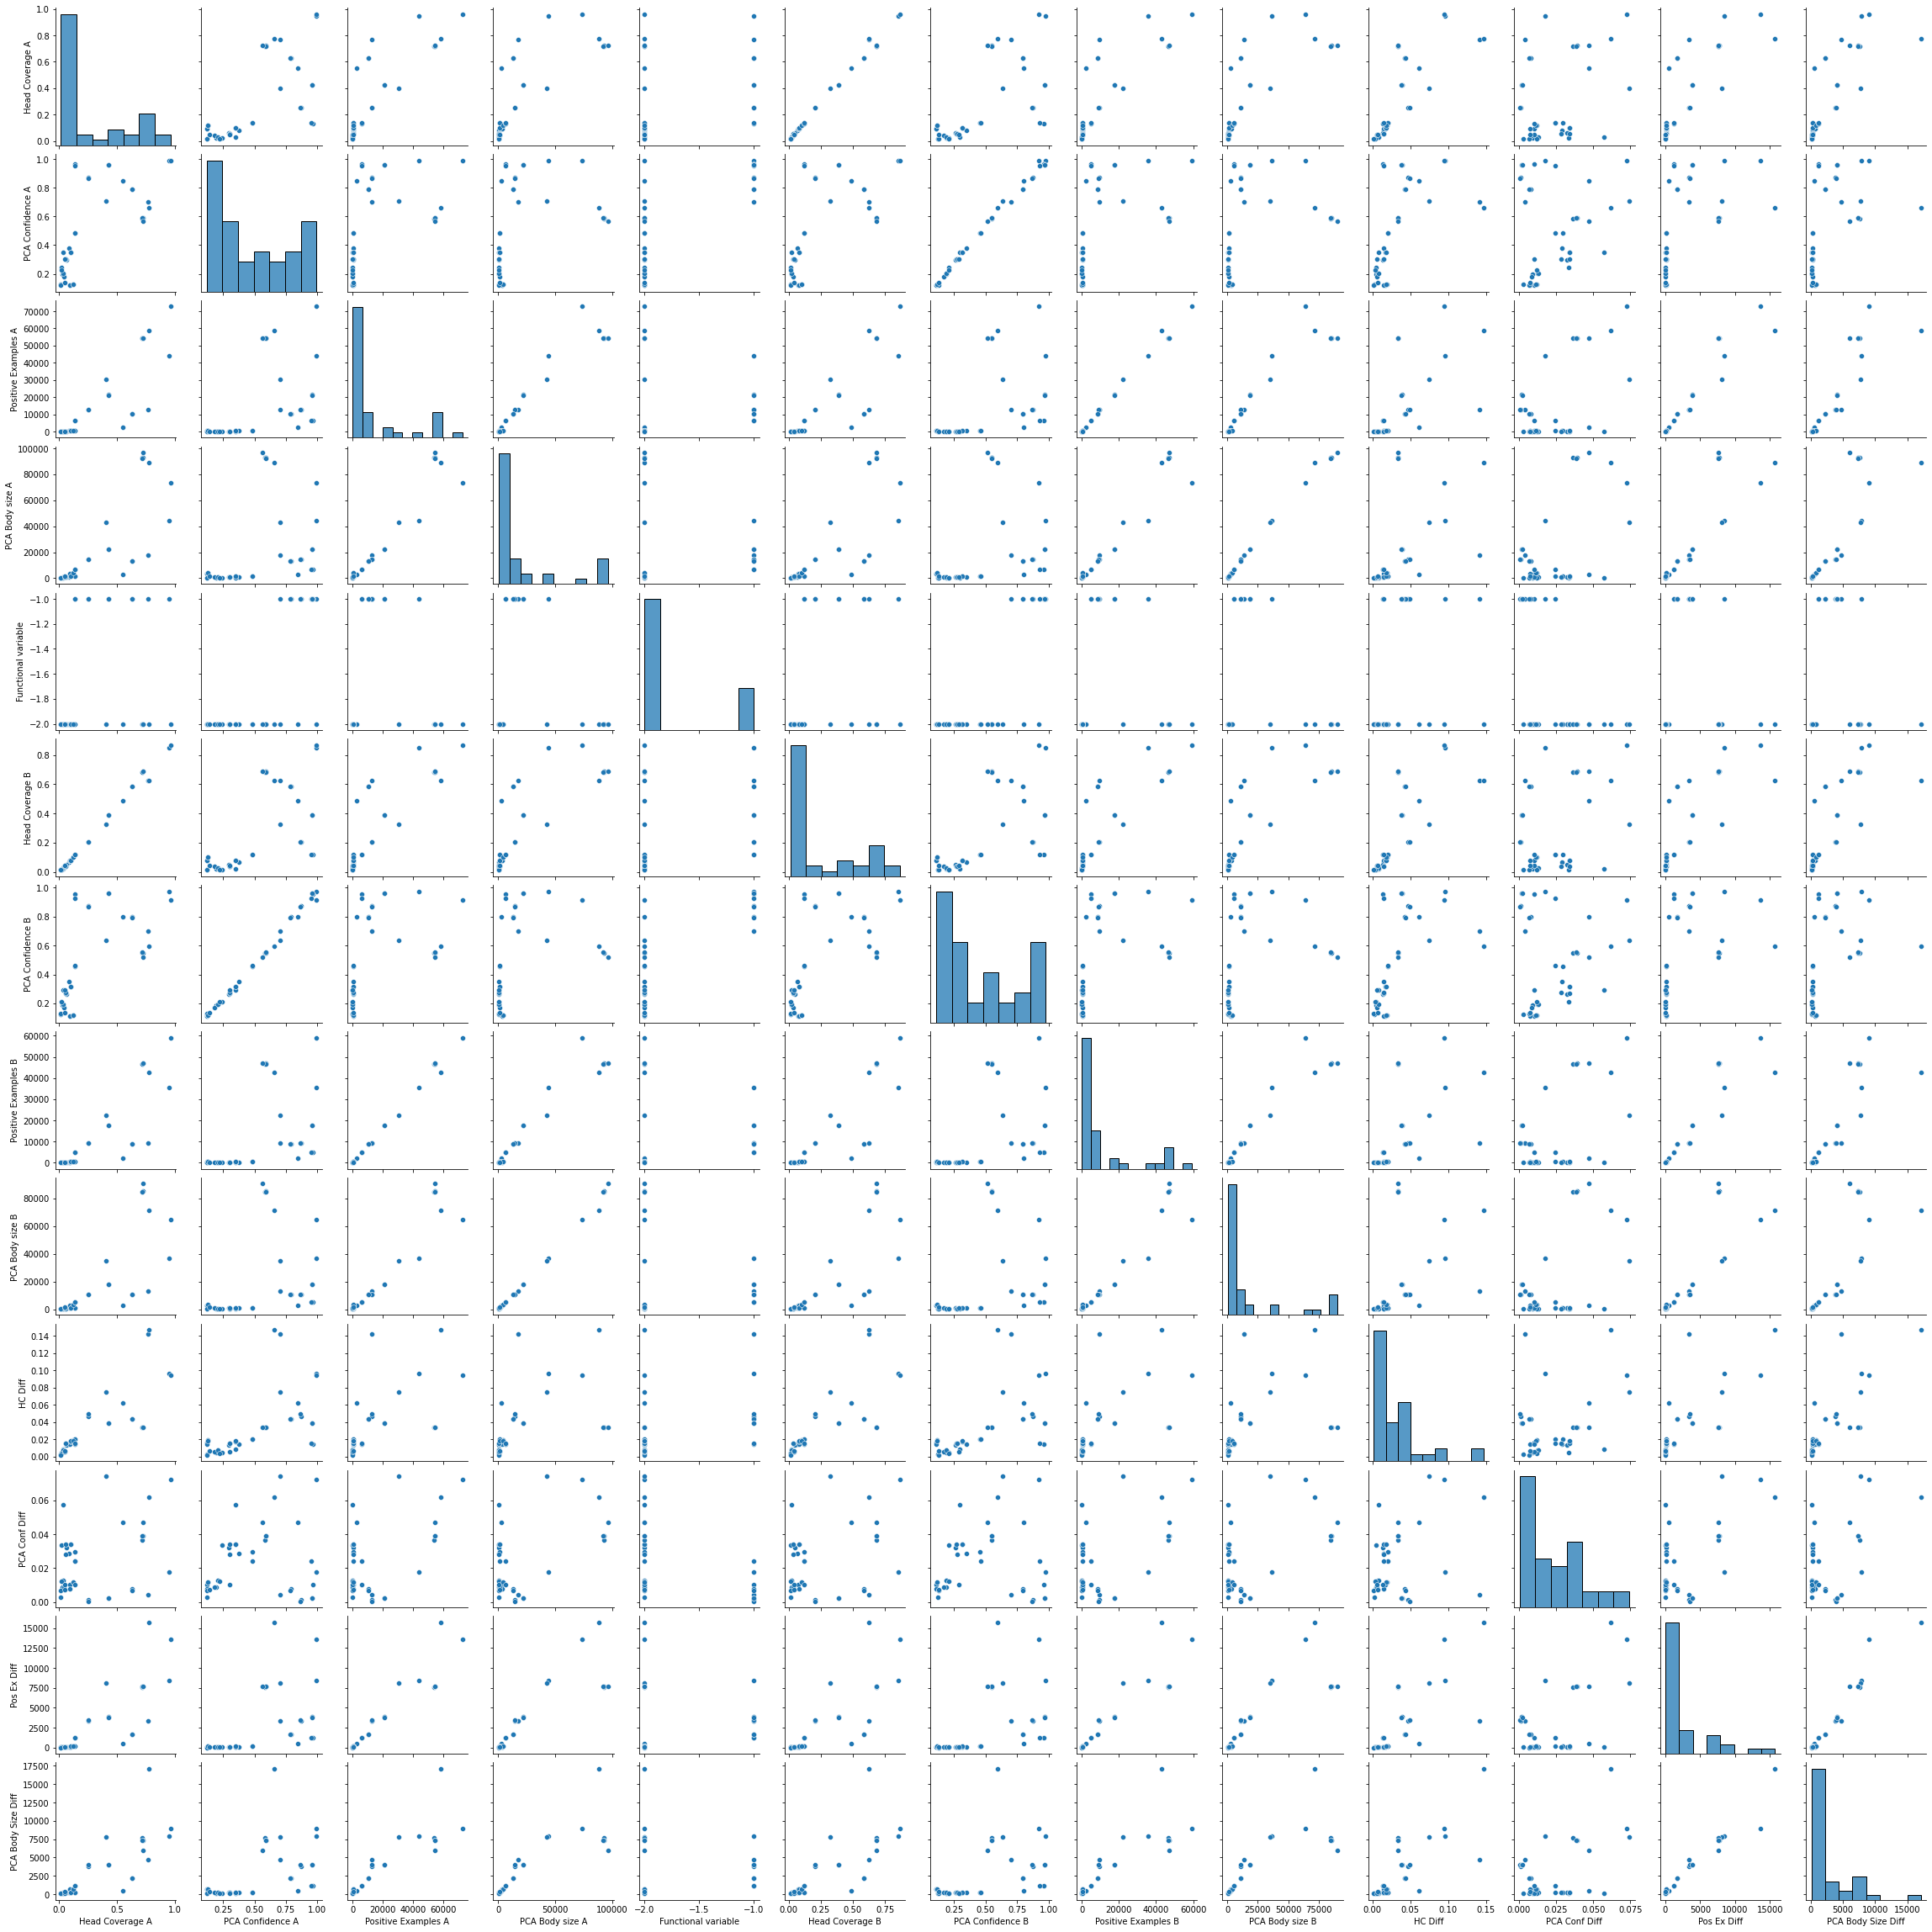

In [156]:
import seaborn as sns
sns.pairplot(commmon_rules)

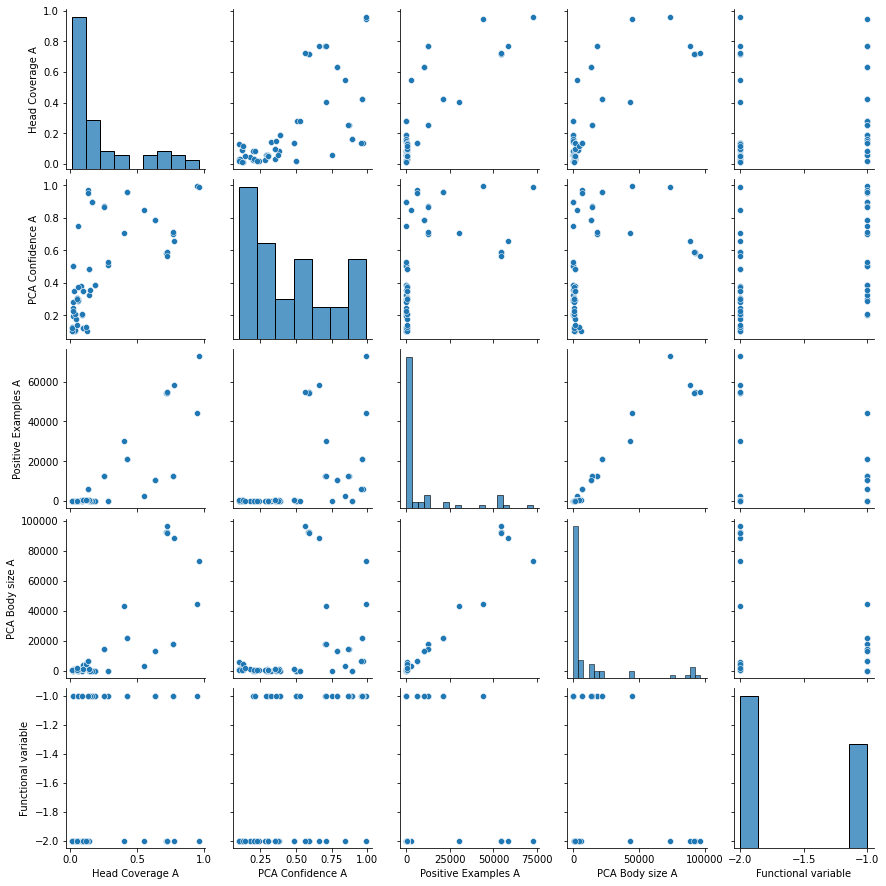

In [157]:
sns.pairplot(family_mining_results)

In [161]:
import matplotlib.pyplot as plt

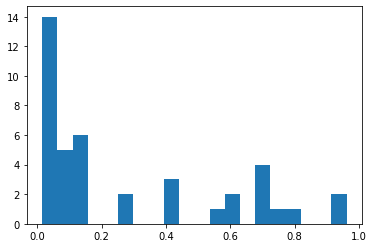

In [170]:
plt.hist(commmon_rules["Head Coverage A"], bins = 20)
plt.show()

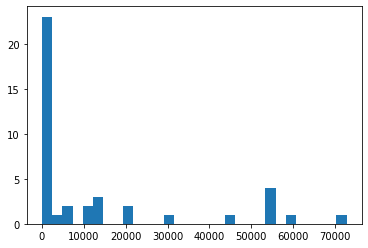

In [180]:
plt.hist(commmon_rules["Positive Examples A"], bins = 30)
plt.show()

---
# 3. Training a model 

AmpliGraph has implemented [several Knoweldge Graph Embedding models](https://docs.ampligraph.org/en/latest/ampligraph.latent_features.html#knowledge-graph-embedding-models) (TransE, ComplEx, DistMult, HolE), but to begin with we're just going to use the [ComplEx](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.ComplEx.html#ampligraph.latent_features.ComplEx) model (with  default values), so lets import that:

In [47]:
X_train, X_test = train_test_split_no_unseen(family_subset, test_size=100) 

In [25]:
top_targets = most_frequent_targets(X_train, n=10000)
top_objects = most_frequent_objects(X_train, n=10000)
entities_subset = np.concatenate([subject_entities, object_entities[~np.isin(object_entities,subject_entities)]])

Our data is now split into train/test sets. If we need to further divide into a validation dataset we can just repeat using the same procedure on the test set (and adjusting the split percentages). 

In [48]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (193258, 3)
Test set size:  (100, 3)


In [53]:
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=10, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

## Filtering negatives

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to **`fit`**, **`evaluate`**, and **`predict`** functions. 

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no *negative* statements generated by the corruption procedure are actually positives. This is simply done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.  


In [50]:
positives_filter = family_subset

## Fitting the model

Once you run the next cell the model will train. 

On a modern laptop this should take ~3 minutes (although your mileage may vary, especially if you've changed any of the hyper-parameters above).

In [54]:
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train, early_stopping = False)

Average ComplEx Loss:   0.032254: 100%|█████| 10/10 [13:58<00:00, 83.87s/epoch]


In [55]:
save_model(model, './Wikidata_family_subset_2_10_epocs.pkl')

This will save the model in the ampligraph_tutorial directory as `best_model.pkl`.

.. we can then delete the model .. 

In [21]:
#del model

.. and then restore it from disk! Ta-da! 

In [76]:
model = restore_model('./Wikidata_family_subset_2_10_epocs.pkl')

In [62]:
model

In [67]:
model.rel_to_idx.keys()

dict_keys(['father', 'mother', 'relative', 'sibling', 'spouse', 'stepparent'])

In [37]:
model

And let's just double check that the model we restored has been fit:

In [23]:
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

The model is fit!


## Running evaluation

In [24]:
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.
WARNING - You are attempting to use 114726 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.


c:\users\johan\appdata\local\programs\python\python37\lib\site-packages\ampligraph\evaluation\protocol.py:952: UserWarning: You are attempting to use 114726 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.
  warnings.warn(warn_msg % ent_for_corruption_size)
100%|████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


In [25]:
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.85
Hits@10: 0.93
Hits@3: 0.91
Hits@1: 0.78


In [33]:
subsubset = family_subset[:1000]

In [65]:
family_subset

array([['Q1000505', 'spouse', 'Q268177'],
       ['Q1000505', 'spouse', 'Q540597'],
       ['Q1000596', 'father', 'Q701504'],
       ...,
       ['Q913574', 'spouse', 'Q235629'],
       ['Q953878', 'relative', 'Q314514'],
       ['Q9749', 'sibling', 'Q706559']], dtype=object)

In [77]:
predictions = discover_facts(family_subset, model, top_n = 1000, max_candidates = 1000, entities_subset = entities_subset, seed = 2)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████████████████████████████████| 1000/1000 [00:14<00:00, 67.00it/s]


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████████████████████████████████| 1000/1000 [00:15<00:00, 64.60it/s]


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████████████████████████████████| 1000/1000 [00:15<00:00, 62.52it/s]


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████████████████████████████████| 1000/1000 [00:12<00:00, 77.89it/s]


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████████████████████████████████| 1000/1000 [00:15<00:00, 65.27it/s]


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████████████████████████████████| 1000/1000 [00:14<00:00, 71.01it/s]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 0 and the array at index 4 has size 1

In [ ]:
predictions

In [47]:
predictions

(array([], shape=(0, 18), dtype=object), array([], dtype=float64))

In [36]:
predictions[0]

array([], shape=(0, 18), dtype=object)

In [30]:
predictions[1]

array([], dtype=float64)

In [32]:
predictions[1].shape

(0,)